># Driving License Extraction OCR Pipeline

This notebook provides a comprehensive workflow for extracting vehicle class and validity date information from scanned images of Sri Lankan driving licenses. It leverages multiple OCR engines (PaddleOCR and Tesseract) and advanced image processing techniques to maximize extraction accuracy, especially for the complex tabular regions where license validity information is stored.

**Key features:**
- **Image orientation correction:** Determines the best rotation angle for OCR by keyword matching using Tessaract.
- **Table region detection:** Locates and extracts the table area of the license containing vehicle classes and dates.
- **Optical Character Recogition:** Uses PaddleOCR for robust text recognition.
- **Intelligent post-processing:** Maps OCR output to known vehicle classes, corrects common misrecognitions, and intelligently pairs dates.
- **Single Image analysis:** Allows manual selection and inspection of results for individual images.
- **Batch processing:** Processes all images in a folder and collates results into a CSV file for further analysis.


---

## Requirements

##### Installing Tesseract OCR on Windows

> **Download the Tesseract installer for Windows:**
   - Go to [UB Mannheim Tesseract builds](https://github.com/UB-Mannheim/tesseract/wiki)
   - Download and install the Tessaract installer for Windows.

> **Note:**  
> Installing `pytesseract` with `pip` only installs the Python wrapper, not the actual Tesseract OCR engine.

---

## Version Compatibility Notice

Version mismatches may cause errors or unexpected behavior. Please ensure you use compatible versions of the following libraries:

| Library      | Version         |
|--------------|----------------|
| **Python**   | 3.11.9         |
| **os**       | builtin        |
| **re**       | builtin        |
| **tempfile** | builtin        |
| **datetime** | builtin        |
| **cv2**      | 4.12.0         |
| **numpy**    | 2.2.6          |
| **pandas**   | 2.3.1          |
| **matplotlib** | 3.10.5       |
| **PIL**      | 11.3.0         |
| **IPython**  | 9.4.0 |
| **paddleocr**| 2.10.0         |
| **paddle**   | 3.0.0          |
| **pytesseract** | 0.3.13      |
| **tqdm**     | 4.67.1         |
| **ipywidgets** | 8.1.7        |

*Tip: Always check your installed versions before running the notebook.*

---

## Importing Libraries

In [1]:
# Import standard libraries
import os
import re
import tempfile
from datetime import datetime
from typing import List, Tuple, Dict, Union
from pathlib import Path

# Import image processing libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML

# Import OCR engines
from paddleocr import PaddleOCR
import pytesseract

# Import progress tracking
import tqdm

# Import widgets for interactive display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Configure matplotlib for better display in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Set Tesseract executable path (adjust for your system)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\Bhagya Dissanayake\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


In [2]:
import sys
import tqdm
import paddle
import paddleocr
import IPython
def print_versions():
    print("Python:", sys.version)
    print("os:", "builtin/no version")
    print("re:", "builtin/no version")
    print("tempfile:", "builtin/no version")
    print("datetime:", "builtin/no version")
    print("cv2:", cv2.__version__)
    print("numpy:", np.__version__)
    print("pandas:", pd.__version__)
    print("matplotlib:", plt.matplotlib.__version__)
    print("PIL:", Image.__version__)
    print("pytesseract:", pytesseract.__version__)
    
    print("tqdm:", tqdm.__version__)
    print("ipywidgets:", widgets.__version__)
print_versions()
print("paddleocr version:", paddleocr.__version__)
print("paddle version:", paddle.__version__)
print(IPython.__version__)

Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
os: builtin/no version
re: builtin/no version
tempfile: builtin/no version
datetime: builtin/no version
cv2: 4.12.0
numpy: 2.2.6
pandas: 2.3.1
matplotlib: 3.10.5
PIL: 11.3.0
pytesseract: 0.3.13
tqdm: 4.67.1
ipywidgets: 8.1.7
paddleocr version: 2.10.0
paddle version: 3.0.0
9.4.0


## Helper Functions for License Processing

#### Image Orientation Adjustment

In [3]:
def best_rotation_by_keyword(image: np.ndarray, 
                             keywords=('Department', 'Motor', 'Traffic', 'Sri', 'Lanka', 'LICENCE', 'Surname', 'Number', 'Date', 'Category'), 
                             verbose: bool=False) -> Tuple[np.ndarray, int, Dict[int, int]]:
    """Determine the best rotation angle for an image by detecting keywords."""
    # Prepare candidate images rotated by 0°, 90°, 180°, and 270° angles
    candidates = [
        (image, 0),  # original image, no rotation
        (cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE), 90),  # rotate 90 degrees clockwise
        (cv2.rotate(image, cv2.ROTATE_180), 180),  # rotate 180 degrees
        (cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE), 270)  # rotate 270 degrees clockwise
    ]

    best_score = -1         # track highest keyword match count found so far
    best_img = image        # image corresponding to the best score (start with original)
    best_angle = 0          # angle corresponding to the best score
    scores = {}             # dictionary to store score per angle

    # Loop over each rotated candidate image and its angle
    for img, angle in candidates:
        # Convert image to grayscale for better OCR performance
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply adaptive thresholding to convert the image to black and white
        proc = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 15)
        
        # Run OCR on the processed image to extract text
        text = pytesseract.image_to_string(proc, config="--psm 6")
        
        # Count how many of the keywords appear in the extracted text (case-insensitive)
        score = sum(1 for k in keywords if k.lower() in text.lower())
        
        # Store this score with its corresponding angle
        scores[angle] = score
        
        # If verbose, print out the current trial angle and how many keywords were found
        if verbose:
            print(f"  Orientation trial angle={angle:3d} score={score} (keywords found)")
        
        # Update best score and best image if this rotation yields more keyword matches
        if score > best_score:
            best_score = score
            best_img = img
            best_angle = angle

    # After checking all rotations, optionally print the final chosen angle and score
    if verbose:
        print(f"  Selected rotation angle={best_angle} with score={best_score}")
    
    return best_img, best_angle, scores

#### Table Region Detection

In [4]:
def locate_table_region(image: np.ndarray, verbose: bool=False) -> np.ndarray:
    """Locate the table region in the license image that likely contains vehicle class information."""
    # Calculate adaptive parameters based on image size
    h, w = image.shape[:2]
    horiz_kernel_size = max(int(w * 0.05), 15)
    vert_kernel_size = max(int(h * 0.05), 15)
    
    # Convert input image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Thresholding
    thresh1 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 31, 9)
    thresh2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, 21, 5)
    bw = cv2.bitwise_or(thresh1, thresh2)
    
    # Morphological operations
    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (horiz_kernel_size, 1))
    vert_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vert_kernel_size))
    horiz = cv2.morphologyEx(bw, cv2.MORPH_OPEN, horiz_kernel, iterations=1)
    vert = cv2.morphologyEx(bw, cv2.MORPH_OPEN, vert_kernel, iterations=1)
    grid = cv2.add(horiz, vert)
    kernel_size = max(3, min(int(min(h, w) * 0.005), 7))
    grid = cv2.dilate(grid, cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size)), iterations=1)

    # Find contours
    contours, _ = cv2.findContours(grid, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    for cnt in contours:
        x, y, ww, hh = cv2.boundingRect(cnt)
        area = ww * hh
        aspect_ratio = ww / float(hh) if hh > 0 else 0
        if 0.1*w < ww < 0.98*w and 0.1*h < hh < 0.95*h and 0.5 < aspect_ratio < 5:
            candidates.append({'contour': cnt, 'rect': (x, y, ww, hh), 'area': area, 'aspect_ratio': aspect_ratio})
    candidates.sort(key=lambda c: c['area'], reverse=True)
    
    if candidates:
        x, y, ww, hh = candidates[0]['rect']
        if verbose:
            print(f"  Table ROI detected at x={x}, y={y}, w={ww}, h={hh}, area={candidates[0]['area']}")
            print(f"  Aspect ratio: {candidates[0]['aspect_ratio']:.2f}")
        return image[y:y+hh, x:x+ww]

    # Edge-based fallback (unchanged)
    if verbose:
        print("  No table detected with grid method, trying edge-based detection...")
    
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, 
                          minLineLength=min(h, w)//4, maxLineGap=20)
    
    if lines is not None and len(lines) > 5:
        mask = np.zeros_like(gray)
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask, (x1, y1), (x2, y2), 255, 2)
        mask = cv2.dilate(mask, np.ones((5, 5), np.uint8), iterations=2)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            cnt = max(contours, key=cv2.contourArea)
            x, y, ww, hh = cv2.boundingRect(cnt)
            if 0.1*w < ww < 0.98*w and 0.1*h < hh < 0.95*h:
                if verbose:
                    print(f"  Table ROI detected with fallback method at x={x}, y={y}, w={ww}, h={hh}")
                return image[y:y+hh, x:x+ww]

    if verbose:
        print("  All detection methods failed; using full image")
    return image

#### OCR

In [5]:
def perform_ocr(image: Union[str, np.ndarray], lang='en', display_image=False) -> Tuple[List[Tuple[str, float]], any]:
    """Perform OCR on an image using PaddleOCR."""
    # Initialize PaddleOCR inside this function
    ocr = PaddleOCR(use_angle_cls=True, lang=lang)
    
    # Handle image input - could be a file path or a numpy array
    if isinstance(image, str):
        # If it's a string, assume it's a file path
        image_path = image
        # Run OCR on the file
        results = ocr.ocr(image_path, cls=True)
    else:
        # If it's a numpy array, save it to a temporary file
        with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp:
            temp_filename = tmp.name
            # Convert to RGB if it's BGR (OpenCV default)
            if image.shape[2] == 3:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Save as JPEG
                cv2.imwrite(temp_filename, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
            else:
                cv2.imwrite(temp_filename, image)
        
        # Run OCR on the temporary file
        results = ocr.ocr(temp_filename, cls=True)
        
        # Clean up the temporary file
        try:
            os.unlink(temp_filename)
        except:
            pass
    
    # Process results
    extracted_text = []
    if results and results[0]:  # Check if results are not empty
        for line in results[0]:
            text = line[1][0]           # Extracted text
            confidence = line[1][1]     # Confidence score
            extracted_text.append((text, confidence))
    
    # Return both the extracted text tuples and the full PaddleOCR results
    return extracted_text, results

#### Data Extraction

In [6]:
def extract_vehicle_classes_and_dates(ocr_results):
    """
    Extracts vehicle classes and their associated dates from OCR results.
    """
    import re
    from datetime import datetime
    
    # Define valid vehicle classes
    valid_vehicle_classes = [
        "A1", "A", "B1", "B", "C1", "C", "CE", "D1", "D", "DE", "G1", "G", "J"
    ]
    
    # Standard progression of classes for assumption #2
    standard_classes = ["A1", "A", "B1", "B", "C1", "C", "CE", "D1", "D", "DE", "G1", "G", "J"]

    # OCR misrecognition mapping dictionary
    ocr_corrections = {
        "T": "1", "|" : "1", "l": "1", "I": "1", "O": "0", "o": "0",
    }
    
    # Common OCR misrecognitions for vehicle classes
    class_corrections = {
        "81": "B1", "8": "B", "C|": "C1", "CI": "C1", "Cl": "C1",
        "DI": "D1", "Dl": "D1", "D|": "D1", "GI": "G1", "Gl": "G1", "G|": "G1",
        "AI": "A1", "Al": "A1", "A|": "A1",
    }

    def correct_ocr_text(text):
        """Correct commonly misrecognized characters in OCR text"""
        # Special case for specific whole strings
        if text in class_corrections:
            return class_corrections[text]
        elif text in ocr_corrections and len(text) > 1:
            return ocr_corrections[text]
            
        return "".join(ocr_corrections.get(char, char) for char in text)
    
    def convert_lone_number_to_class(text):
        """Convert lone numbers to potential vehicle classes if possible"""
        # Check if this might be a class incorrectly recognized
        text = text.strip().upper()
        if text in class_corrections:
            return class_corrections[text]
            
        # Try to match patterns like "81" to "B1" or similar conversions
        common_replacements = {
            "81": "B1", "A1": "A1", "8": "B", "A": "A", 
            "C1": "C1", "C": "C", "D1": "D1", "D": "D",
            "G1": "G1", "G": "G", "J": "J"
        }
        
        if text in common_replacements:
            return common_replacements[text]
            
        return None  # Not convertible to a valid class

    def normalize_date_string(s):
        """Convert various date formats to standard DD.MM.YYYY format"""
        orig = s
        s = s.strip().replace(" ", "")
        
        # Already in correct format
        if re.match(r"\d{1,2}\.\d{1,2}\.\d{4}$", s):
            return s
            
        # Replace various separators with dots
        s2 = re.sub(r"[/:,-]", ".", s)
        if re.match(r"\d{1,2}\.\d{1,2}\.\d{4}$", s2):
            return s2
            
        # Handle 8-digit format (DDMMYYYY)
        if re.match(r"^\d{8}$", s2):
            return f"{s2[:2]}.{s2[2:4]}.{s2[4:]}"
            
        # Handle formats with various spacing
        m = re.match(r"^(\d{2})[. ]?(\d{2,4})[. ]?(\d{4})$", s)
        if m:
            day = m.group(1)
            month = m.group(2)
            year = m.group(3)
            if len(month) == 2:
                return f"{day}.{month}.{year}"
            elif len(month) == 4:
                return f"{day}.{month[:2]}.{month[2:]}"
                
        # Try to extract just the numbers and format them
        nums = re.findall(r"\d+", s)
        if len(nums) == 3:
            return f"{nums[0]}.{nums[1]}.{nums[2]}"
            
        return orig
    
    def add_expiry_date(start_date_str):
        """Calculate an expiry date 8 years from the start date if after 2012"""
        if not start_date_str:
            return None
            
        try:
            start_date = datetime.strptime(start_date_str, "%d.%m.%Y")
            # Check if year is after 2012
            if start_date.year > 2012:
                expiry_date = datetime(start_date.year + 8, start_date.month, start_date.day)
                return expiry_date.strftime("%d.%m.%Y")
        except Exception:
            pass
            
        return None
        
    def is_valid_date_string(s):
        """Check if string can be parsed as a valid date"""
        try:
            datetime.strptime(s, "%d.%m.%Y")
            return True
        except Exception:
            return False
            
    def validate_date(date_str):
        """Ensure dates don't exceed the current year (2024)"""
        if not date_str:
            return None
            
        try:
            date_obj = datetime.strptime(date_str, "%d.%m.%Y")
            if date_obj.year > 2024:  # Check if date exceeds 2024
                return None
            return date_str
        except Exception:
            return None

    # Check if results are empty
    if not ocr_results or not ocr_results[0]:
        # Return all classes with empty dates if no OCR results
        return [{"class": cls, "start_date": None, "expiry_date": None, "confidence": 0.0} 
                for cls in standard_classes]

    # Extract text and confidence from OCR results
    extracted_texts = [(line[1][0], line[1][1]) for line in ocr_results[0]]
    
    # First pass - look for recognized vehicle classes and collect standalone dates
    results = []
    classes_found = set()
    standalone_dates = []
    found_dates = set()
    
    # Process the extracted text to find vehicle classes and dates
    for idx, (text, conf) in enumerate(extracted_texts):
        corrected_text = correct_ocr_text(text)
        
        # If we find a vehicle class
        if corrected_text in valid_vehicle_classes:
            classes_found.add(corrected_text)
            entry = {"class": corrected_text, "start_date": None, "expiry_date": None, "confidence": conf}
            dates_found = []
            
            # Look ahead for dates associated with this vehicle class
            scan_idx = idx + 1
            while scan_idx < len(extracted_texts):
                next_text = extracted_texts[scan_idx][0]
                next_corrected = correct_ocr_text(next_text)
                
                # Stop if we hit another vehicle class
                if next_corrected in valid_vehicle_classes:
                    break
                    
                norm_date = normalize_date_string(next_corrected)
                # Try to parse normalized date
                if is_valid_date_string(norm_date):
                    dates_found.append(norm_date)
                    found_dates.add(norm_date)  # Track all found dates
                    
                scan_idx += 1
                
            # Assign dates found to start and expiry fields
            if len(dates_found) >= 2:
                # Sort dates chronologically
                date_objs = [datetime.strptime(d, "%d.%m.%Y") for d in dates_found[:2]]
                if date_objs[0] < date_objs[1]:
                    entry["start_date"] = validate_date(dates_found[0])
                    entry["expiry_date"] = dates_found[1]
                else:
                    entry["start_date"] = validate_date(dates_found[1])
                    entry["expiry_date"] = dates_found[0]
            elif len(dates_found) == 1:
                entry["start_date"] = validate_date(dates_found[0])
                # Calculate expiry date if start date > 2012
                entry["expiry_date"] = add_expiry_date(entry["start_date"])
                
            results.append(entry)
        else:
            # Check if this might be a standalone date
            norm_date = normalize_date_string(corrected_text)
            if is_valid_date_string(norm_date) and norm_date not in found_dates:
                standalone_dates.append((norm_date, conf))
                found_dates.add(norm_date)
    
    # Second pass - try to convert lone numbers to classes
    for idx, (text, conf) in enumerate(extracted_texts):
        # Only process if it's not already a recognized class
        potential_class = convert_lone_number_to_class(text)
        if potential_class and potential_class not in classes_found and potential_class in valid_vehicle_classes:
            classes_found.add(potential_class)
            entry = {"class": potential_class, "start_date": None, "expiry_date": None, "confidence": conf}
            dates_found = []
            
            # Look ahead for dates associated with this potential class
            scan_idx = idx + 1
            while scan_idx < len(extracted_texts):
                next_text = extracted_texts[scan_idx][0]
                next_corrected = correct_ocr_text(next_text)
                
                # Stop if we hit another vehicle class
                if next_corrected in valid_vehicle_classes or convert_lone_number_to_class(next_corrected) in valid_vehicle_classes:
                    break
                    
                norm_date = normalize_date_string(next_corrected)
                # Try to parse normalized date
                if is_valid_date_string(norm_date):
                    dates_found.append(norm_date)
                    
                scan_idx += 1
                
            # Assign dates found to start and expiry fields
            if len(dates_found) >= 2:
                # Sort dates chronologically
                date_objs = [datetime.strptime(d, "%d.%m.%Y") for d in dates_found[:2]]
                if date_objs[0] < date_objs[1]:
                    entry["start_date"] = validate_date(dates_found[0])
                    entry["expiry_date"] = dates_found[1]
                else:
                    entry["start_date"] = validate_date(dates_found[1])
                    entry["expiry_date"] = dates_found[0]
            elif len(dates_found) == 1:
                entry["start_date"] = validate_date(dates_found[0])
                # Calculate expiry date if start date > 2012
                entry["expiry_date"] = add_expiry_date(entry["start_date"])
                
            results.append(entry)
    
    # Third pass - intelligent date pairing and assignment to unrecognized classes
    if standalone_dates:
        # Apply intelligent date pairing based on realistic license periods
        paired_dates = []
        i = 0
        while i < len(standalone_dates):
            if i + 1 < len(standalone_dates):
                date1 = datetime.strptime(standalone_dates[i][0], "%d.%m.%Y")
                date2 = datetime.strptime(standalone_dates[i+1][0], "%d.%m.%Y")
                
                # If dates are within reasonable license timeframe (6-9 years)
                year_diff = abs(date2.year - date1.year)
                if 6 <= year_diff <= 9:
                    # These are likely start/expiry pair
                    if date1 < date2:
                        start_date = validate_date(standalone_dates[i][0])
                        paired_dates.append(((start_date, standalone_dates[i+1][0]), 
                                            (standalone_dates[i][1] + standalone_dates[i+1][1])/2))
                    else:
                        start_date = validate_date(standalone_dates[i+1][0])
                        paired_dates.append(((start_date, standalone_dates[i][0]), 
                                            (standalone_dates[i][1] + standalone_dates[i+1][1])/2))
                    i += 2
                    continue
            
            # Single date
            start_date = validate_date(standalone_dates[i][0])
            paired_dates.append(((start_date, add_expiry_date(start_date)), 
                                standalone_dates[i][1]))
            i += 1
            
        # Assign standalone date pairs to vehicle classes that haven't been found yet
        unassigned_classes = [cls for cls in standard_classes if cls not in classes_found]
        
        for i, ((start_date, expiry_date), conf) in enumerate(paired_dates):
            if i < len(unassigned_classes) and start_date is not None:
                results.append({
                    "class": unassigned_classes[i],
                    "start_date": start_date,
                    "expiry_date": expiry_date,
                    "confidence": conf
                })
    
    # Filter out duplicate vehicle classes, preferring entries with dates
    def filter_duplicate_classes(entries):
        """Remove duplicate vehicle classes, keeping the entry with most date information"""
        class_groups = {}
        # Group entries by vehicle class
        for entry in entries:
            vehicle_class = entry["class"]
            if vehicle_class not in class_groups:
                class_groups[vehicle_class] = []
            class_groups[vehicle_class].append(entry)
        
        # For each group, select the best entry
        filtered_results = []
        for vehicle_class, entries in class_groups.items():
            if len(entries) == 1:
                filtered_results.append(entries[0])
            else:
                # Score entries by date information
                best_entry = None
                best_score = -1
                
                for entry in entries:
                    # Score based on date information - having both dates is better than one date
                    score = 0
                    if entry["start_date"]:
                        score += 1
                    if entry["expiry_date"]:
                        score += 1
                    # Use confidence as a tiebreaker
                    if score > best_score or (score == best_score and entry["confidence"] > best_entry["confidence"]):
                        best_score = score
                        best_entry = entry
                
                filtered_results.append(best_entry)
        
        return filtered_results

    # Apply the filter before returning
    filtered_results = filter_duplicate_classes(results)
    
    # Ensure all standard classes are present in the output
    final_results = []
    classes_in_results = {entry["class"] for entry in filtered_results}
    
    # Add all filtered results to final results
    final_results.extend(filtered_results)
    
    # Add any missing classes with empty dates
    for cls in standard_classes:
        if cls not in classes_in_results:
            final_results.append({
                "class": cls,
                "start_date": None,
                "expiry_date": None,
                "confidence": 0.0  # Default confidence for undetected classes
            })
    
    # Sort results to ensure the order of vehicle classes follows the standard progression
    # This ensures A1, A, B1, B appear in the correct order
    class_order = {cls: idx for idx, cls in enumerate(standard_classes)}
    final_results.sort(key=lambda x: class_order.get(x["class"], float('inf')))
    
    return final_results

## Single Image Processing

This function processes a single image and displays all intermediate steps and results.

In [7]:
def process_and_display_image(img_path):
    """Process an image and display."""
    print(f"\nProcessing image: {os.path.basename(img_path)}")
    
    # Step 1: Load the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to load image: {img_path}")
        return None
    
    # Step 2: Find the best rotation
    rotated_img, angle, scores = best_rotation_by_keyword(image, verbose=True)
    
    # Step 3: Locate the table region from the rotated image
    table_region = locate_table_region(rotated_img, verbose=True)
    
    # Step 4: Perform OCR on the table region
    extracted_text, ocr_results = perform_ocr(table_region)
    
    # Step 5: Extract vehicle classes and dates from OCR results
    vehicle_info = extract_vehicle_classes_and_dates(ocr_results)
    
    # Display only the original image and table region
    plt.figure(figsize=(10, 8))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Extracted Table Region")
    plt.imshow(cv2.cvtColor(table_region, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display OCR text results
    print("\nOCR Results:")
    print("-" * 50)
    if extracted_text:
        for idx, (text, conf) in enumerate(extracted_text):
            print(f"{idx+1:2d}: '{text}' (confidence: {conf:.2f})")
    else:
        print("No text extracted")
        
    # Create a DataFrame of the results
    results_data = []
    for info in vehicle_info:
        results_data.append({
            'image_name': os.path.basename(img_path),
            'vehicle_class': info.get('class', ''),
            'start_date': info.get('start_date', ''),
            'expiry_date': info.get('expiry_date', ''),
            'confidence': info.get('confidence', 0)
        })
    
    if not results_data:
        results_data = [{
            'image_name': os.path.basename(img_path),
            'vehicle_class': 'N/A',
            'start_date': 'N/A',
            'expiry_date': 'N/A',
            'confidence': 0
        }]
    
    return pd.DataFrame(results_data)

### Find and List All Images in the Target Folder

In [8]:
def find_image_files(folder_path, reverse=True):
    """Find all jpg files in a folder and return a sorted list.
    
    Args:
        folder_path: Path to the folder containing images
    """
    # Find all JPG files in the directory, avoiding duplicates
    # Use a set to store unique file paths by their lowercase name
    unique_files = set()
    for img_path in Path(folder_path).glob('*.[jJ][pP][gG]'):
        unique_files.add(str(img_path))
    
    # Convert back to list and sort (reverse=True for descending order)
    image_paths = sorted(list(unique_files), reverse=reverse)
    
    return image_paths

In [9]:
# Set the folder path containing license images
folder_path = "Images"  # Change this to your folder path

# Get list of all images in the folder
image_paths = find_image_files(folder_path)
print(f"Found {len(image_paths)} images in {folder_path}")

# Create a dropdown for selecting images
image_names = [os.path.basename(path) for path in image_paths]
image_dict = dict(zip(image_names, image_paths))

Found 99 images in Images


## Single Image Output


Processing image: 374029.jpg
  Orientation trial angle=  0 score=0 (keywords found)
  Orientation trial angle= 90 score=0 (keywords found)
  Orientation trial angle=180 score=0 (keywords found)
  Orientation trial angle=270 score=6 (keywords found)
  Selected rotation angle=270 with score=6
  Table ROI detected at x=328, y=143, w=711, h=550, area=391050
  Aspect ratio: 1.29
[2025/08/18 03:51:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Bhagya Dissanayake/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_

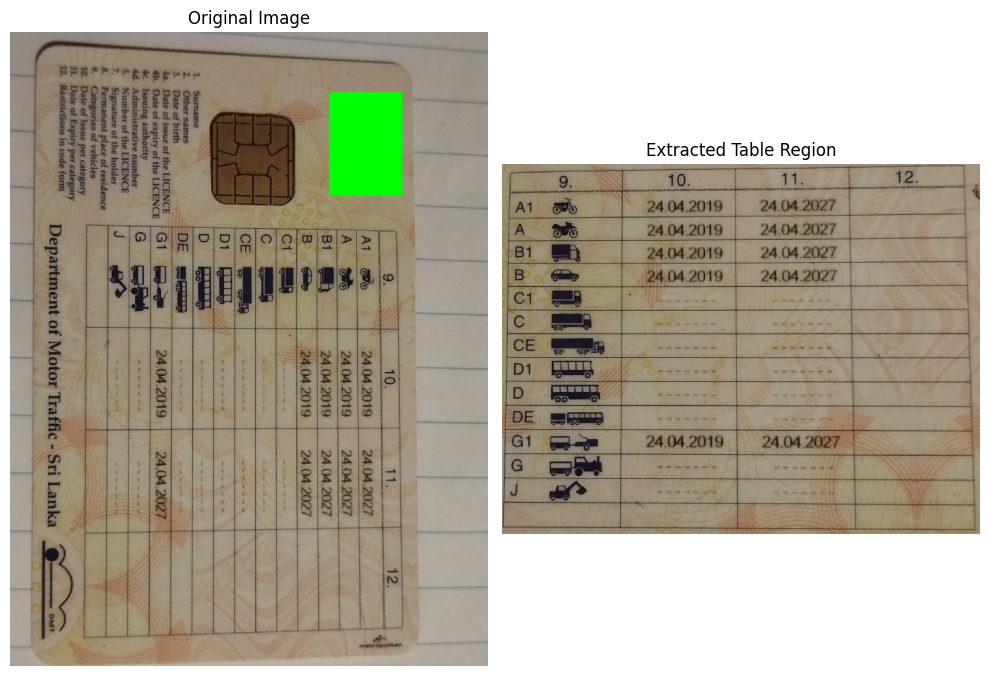


OCR Results:
--------------------------------------------------
 1: '9' (confidence: 0.62)
 2: '10.' (confidence: 0.99)
 3: '11.' (confidence: 0.98)
 4: '12.' (confidence: 0.98)
 5: 'A1' (confidence: 1.00)
 6: '24.04.2019' (confidence: 1.00)
 7: '24.04.2027' (confidence: 0.99)
 8: 'A' (confidence: 1.00)
 9: '24.04.2019' (confidence: 0.99)
10: '24.04.2027' (confidence: 0.99)
11: 'B1' (confidence: 1.00)
12: '24.04.2019' (confidence: 0.99)
13: '24.04.2027' (confidence: 0.99)
14: 'B' (confidence: 0.99)
15: '24.04.2019' (confidence: 0.98)
16: '24.04.2027' (confidence: 0.99)
17: 'C1' (confidence: 1.00)
18: 'C' (confidence: 0.85)
19: 'CE' (confidence: 1.00)
20: 'D1' (confidence: 1.00)
21: 'D' (confidence: 1.00)
22: 'DE' (confidence: 1.00)
23: 'G1' (confidence: 1.00)
24: '24.04.2019' (confidence: 1.00)
25: '24.04.2027' (confidence: 0.99)
26: 'G' (confidence: 1.00)
27: 'J' (confidence: 0.97)


,image_name,vehicle_class,start_date,expiry_date,confidence
0,374029.jpg,A1,24.04.2019,24.04.2027,0.998774
1,374029.jpg,A,24.04.2019,24.04.2027,0.999430
2,374029.jpg,B1,24.04.2019,24.04.2027,0.995438
3,374029.jpg,B,24.04.2019,24.04.2027,0.990590
4,374029.jpg,C1,None,None,0.996615
5,374029.jpg,C,None,None,0.854440
6,374029.jpg,CE,None,None,0.996545
7,374029.jpg,D1,None,None,0.997962
8,374029.jpg,D,None,None,0.997790
9,374029.jpg,DE,None,None,0.998444


In [10]:
# Manual Input (Non-Interactive)
img_path = r"Images\374029.jpg"  # Replace with your actual image path
output_df = process_and_display_image(img_path)
display(output_df)

---

#### Batch processing already completed in other notebook, hence skipped.

# Batch Processing

In [ ]:
def process_all_images(image_paths):
    """Process all images and collect results into a DataFrame."""
    all_results = []
    
    for img_path in tqdm.tqdm(image_paths, desc="Processing images"):
        # Step 1: Load the image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Failed to load image: {img_path}")
            continue
            
        try:
            # Step 2: Find the best rotation
            rotated_img, angle, _ = best_rotation_by_keyword(image, verbose=False)
            
            # Step 3: Locate the table region from the rotated image
            table_region = locate_table_region(rotated_img, verbose=False)
            
            # Step 4: Perform OCR on the table region
            _, ocr_results = perform_ocr(table_region)
            
            # Step 5: Extract vehicle classes and dates from OCR results
            vehicle_info = extract_vehicle_classes_and_dates(ocr_results)
            
            # Add to results list
            if vehicle_info:
                for info in vehicle_info:
                    all_results.append({
                        'image_name': os.path.basename(img_path),
                        'vehicle_class': info.get('class', ''),
                        'start_date': info.get('start_date', ''),
                        'expiry_date': info.get('expiry_date', ''),
                        'confidence': info.get('confidence', 0),
                        'rotation_angle': angle
                    })
            else:
                all_results.append({
                    'image_name': os.path.basename(img_path),
                    'vehicle_class': '',
                    'start_date': '',
                    'expiry_date': '',
                    'confidence': 0,
                    'rotation_angle': angle
                })
                
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            all_results.append({
                'image_name': os.path.basename(img_path),
                'vehicle_class': 'ERROR',
                'start_date': '',
                'expiry_date': '',
                'confidence': 0,
                'rotation_angle': 0,
                'error': str(e)
            })
    
    # Create DataFrame
    return pd.DataFrame(all_results)

In [ ]:
# Process all images (this may take some time)
all_results_df = process_all_images(image_paths)

## View and Export All Results

In [ ]:
# Display the summary table of all results
display(all_results_df)

In [ ]:
# Export results to CSV
all_results_df.to_csv('license_extraction_df.csv', index=False)
print("Results saved to 'license_extraction_df.csv'")

---